<a href="https://colab.research.google.com/github/DanielCalero1/Smooking-recognition/blob/ResNet/Experiments_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torchvision


In [1]:
from torchvision import models

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

Mounted at /content/drive


<ipython-input-1-d4fff5e1aa1e>:26: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
resnet50 = models.resnet50(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dir = '/content/drive/MyDrive/Dataset-1/training_data'
val_dir = '/content/drive/MyDrive/Dataset-1/validation_data'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

##Testing the model without additional training

In [ ]:
'''
First, we need to change the last layer of resnet to have only two (or only one?) output. Resnet was trained
to predict images within a set of 100 classes. In our case we only have two classes.
'''
resnet50.fc = nn.Linear(resnet50.fc.in_features, 1)

resnet50.eval()

predictions = []
labels = []
with torch.no_grad():
    for images, targets in val_loader:
        outputs=resnet50(images)

        probs = torch.sigmoid(outputs).squeeze()
        predicted_classes = (probs > 0.5).long()
        predictions.extend(predicted_classes.numpy())
        labels.extend(targets.numpy())

accuracy = accuracy_score(labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

KeyboardInterrupt: 

###Fine-Tunning ResNet GPU

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(pretrained=True)

num_features = resnet50.fc.in_features

In [ ]:

resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 1)  # Solo 1 salida
)
resnet50.to(device)

for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True

resnet50.train()
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()  # Incluye Sigmoid
num_epochs = 8
epoch_loss=[]
epoch_accuracy=[]
for epoch in range(num_epochs):
    running_loss=0.0
    correct=0
    total=0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs=resnet50(images)
        loss=criterion(outputs.squeeze(),targets.float())
        loss.backward()
        optimizer.step()
        predicted_class= (outputs.squeeze() > 0.5).long()
        correct += ((predicted_class == targets).long()).sum().item()
        total+=targets.size(0) #what does this line do
        running_loss+=loss.item()
    epoch_loss.append(running_loss/len(train_loader))
    epoch_accuracy.append(correct/total *100)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss[epoch]:.4f}, Accuracy: {epoch_accuracy[epoch]:.4f}')

Epoch 1/8, Loss: 1.2890, Accuracy: 56.6238
Epoch 2/8, Loss: 0.5091, Accuracy: 70.7040
Epoch 3/8, Loss: 0.3330, Accuracy: 85.2385
Epoch 4/8, Loss: 0.3166, Accuracy: 85.0114
Epoch 5/8, Loss: 0.2739, Accuracy: 88.4179
Epoch 6/8, Loss: 0.2835, Accuracy: 87.7366
Epoch 7/8, Loss: 0.2691, Accuracy: 88.5693
Epoch 8/8, Loss: 0.2281, Accuracy: 90.3861


###Fine Tuning ResNet in CPU

In [ ]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Solo 1 salida
    nn.Sigmoid()  # Sigmoid para probabilidad entre 0 y 1
)
resnet50.train()
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
num_epochs=4

for epoch in range(num_epochs):
    running_loss=0.0
    correct=0
    total=0
    for images, targets in train_loader:
        optimizer.zero_grad()
        outputs=resnet50(images)
        loss=criterion(outputs.squeeze(),targets.float())
        loss.backward()
        optimizer.step()
        predicted_class= (outputs.squeeze() > 0.5).long()
        correct += ((predicted_class == targets).long()).sum().item()
        total+=targets.size(0) #what does this line do
        running_loss+=loss.item()
    epoch_loss=running_loss/len(train_loader)
    epoch_accuracy=correct/total *100
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')


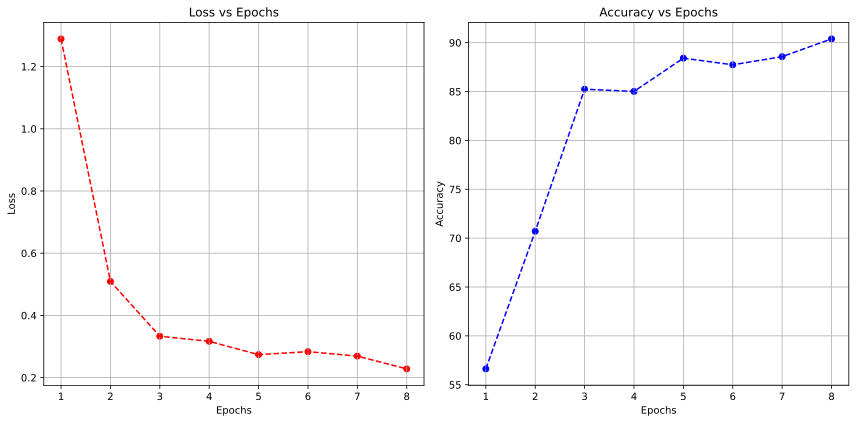

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos del experimento
epochs = [1, 2, 3, 4,5,6,7,8]
losses=epoch_loss
accuracies = epoch_accuracy

# Crear el DataFrame de Pandas
df = pd.DataFrame({
    'Epochs': epochs,
    'Loss': losses,
    'Accuracy': accuracies
})

# Mostrar el DataFrame
df

# Graficar loss vs epochs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df['Epochs'], df['Loss'], color='red', label='Loss')
plt.plot(df['Epochs'], df['Loss'], color='red', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid(True)

# Graficar accuracy vs epochs
plt.subplot(1, 2, 2)
plt.scatter(df['Epochs'], df['Accuracy'], color='blue', label='Accuracy')
plt.plot(df['Epochs'], df['Accuracy'], color='blue', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.grid(True)

# Mostrar ambas gráficas
plt.tight_layout()
plt.savefig('loss_accuracy_plot.png')
plt.show()


###Computing the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Asegúrate de que tu modelo esté en modo evaluación
resnet50.eval()
all_preds = []
all_targets = []

# Desactiva el cálculo de gradientes para acelerar el proceso
with torch.no_grad():
    for images, targets in val_loader:  # Usa tu loader de validación aquí
        images, targets = images.to(device), targets.to(device)

        outputs = resnet50(images)
        predicted_class = (outputs.squeeze() > 0.5).long()

        all_preds.extend(predicted_class.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(all_targets, all_preds)

print("Matriz de Confusión:")
print(conf_matrix)


Matriz de Confusión:
[[184  16]
 [ 50 150]]


###Evaluating models accuracy on the validation data on the cpu

In [ ]:

resnet50.eval()  # Poner el modelo en modo de evaluación
val_predictions = []
val_labels = []

with torch.no_grad():
    for images, targets in val_loader:
        outputs = resnet50(images)
        predicted_class= (outputs.squeeze() > 0.5).long()
        val_predictions.extend(predicted_class.cpu().numpy())
        val_labels.extend(targets.cpu().numpy())

# Calcular precisión en el conjunto de validación
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Precisión en el conjunto de validación: {accuracy * 100:. 2f}%")


###Evluating models accuracy on the GPU


In [ ]:
# Asegúrate de que el modelo esté en el dispositivo correcto (GPU si disponible)
resnet50.eval()  # Poner el modelo en modo de evaluación

# Si ya has definido `device`, asegúrate de que los tensores estén en el mismo dispositivo
val_predictions = []
val_labels = []

with torch.no_grad():
    for images, targets in val_loader:
        # Mover imágenes y etiquetas a la GPU (o CPU si no está disponible)
        images, targets = images.to(device), targets.to(device)

        # Realizar la predicción
        outputs = resnet50(images)

        # Clasificación binaria, predicción 0 o 1
        predicted_class = (outputs.squeeze() > 0.5).long()

        # Guardar predicciones y etiquetas
        val_predictions.extend(predicted_class.cpu().numpy())
        val_labels.extend(targets.cpu().numpy())

# Calcular precisión en el conjunto de validación
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Precisión en el conjunto de validación: {accuracy * 100:.2f}%")

Precisión en el conjunto de validación: 83.50%


###Experimenting with the learning rate (GPU)

In [ ]:
from sklearn.metrics import confusion_matrix

# Re-definir la capa final de ResNet50 (solo 1 salida)
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 1)  # Solo 1 salida
)
resnet50.to(device)  # Mover el modelo a la GPU o CPU según corresponda

# Congelar todos los parámetros de ResNet50 excepto la capa final
for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True

# Ahora iteramos sobre los learning rates
learning_rates = np.linspace(0.1, 1.0, 6)

all_val_accuracies = []  # Lista de precisión en validación por learning rate
all_confusion_matrices = []  # Lista de matrices de confusión por learning rate

# Lista para almacenar epoch_loss y epoch_accuracy por cada learning rate
all_epoch_losses = []  # Para almacenar las pérdidas de entrenamiento
all_epoch_accuracies = []  # Para almacenar las precisiones de entrenamiento

for lr in learning_rates:
    # Re-inicializar el optimizador con el learning rate actual
    optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # Incluye Sigmoid
    num_epochs = 8

    # Listas para almacenar el accuracy en entrenamiento y validación
    epoch_loss = []
    epoch_accuracy = []
    val_accuracies = []

    # Entrenamiento
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Entrenamiento en el conjunto de entrenamiento
        resnet50.train()  # Asegurarse de que el modelo esté en modo entrenamiento
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = resnet50(images)
            loss = criterion(outputs.squeeze(), targets.float())
            loss.backward()
            optimizer.step()
            predicted_class = (outputs.squeeze() > 0.5).long()
            correct += ((predicted_class == targets).long()).sum().item()
            total += targets.size(0)
            running_loss += loss.item()

        epoch_loss.append(running_loss / len(train_loader))
        epoch_accuracy.append(correct / total * 100)

        # Evaluación en el conjunto de validación después de cada epoch
        resnet50.eval()  # Poner el modelo en modo de evaluación
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Desactivar gradientes para la evaluación
            for val_images, val_targets in val_loader:
                val_images, val_targets = val_images.to(device), val_targets.to(device)
                val_outputs = resnet50(val_images)
                val_predicted_class = (val_outputs.squeeze() > 0.5).long()
                val_correct += (val_predicted_class == val_targets).sum().item()
                val_total += val_targets.size(0)

        val_accuracy = val_correct / val_total * 100
        val_accuracies.append(val_accuracy)

    # Guardar epoch_loss y epoch_accuracy para este learning rate
    all_epoch_losses.append(epoch_loss)
    all_epoch_accuracies.append(epoch_accuracy)

    # Al finalizar el entrenamiento con este learning rate, calcular la matriz de confusión
    resnet50.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for val_images, val_targets in val_loader:
            val_images, val_targets = val_images.to(device), val_targets.to(device)
            val_outputs = resnet50(val_images)
            predicted_class = (val_outputs.squeeze() > 0.5).long()
            val_predictions.extend(predicted_class.cpu().numpy())
            val_labels.extend(val_targets.cpu().numpy())

    # Calcular la matriz de confusión
    cm = confusion_matrix(val_labels, val_predictions)
    all_confusion_matrices.append(cm)

    # Guardar la precisión de validación para este learning rate
    all_val_accuracies.append(val_accuracies)

    # Imprimir resultados finales para este learning rate
    print(f"Resultados con learning rate = {lr}:")
    print(f"Precisión final en validación: {val_accuracies[-1]:.2f}%")
    print(f"Matriz de confusión:\n{cm}")



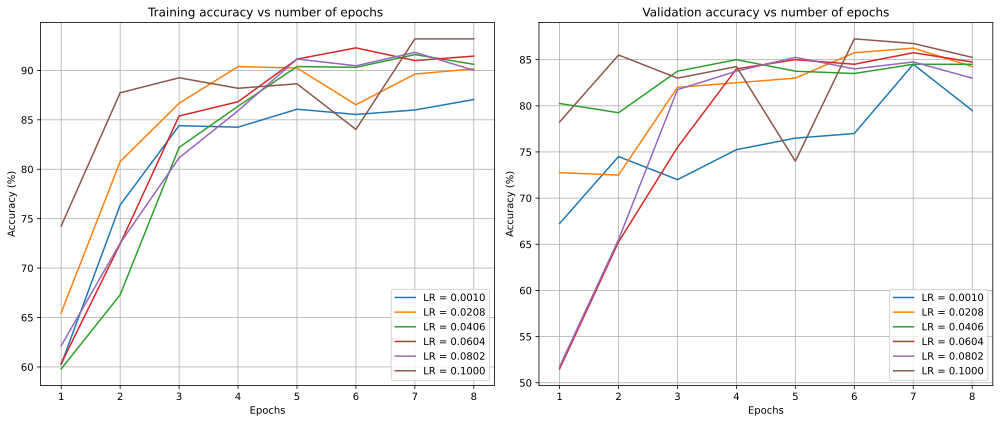

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for i, lr in enumerate(learning_rates):
    ax1.plot(range(1, num_epochs + 1), all_epoch_accuracies[i], label=f'LR = {lr:.4f}')

ax1.set_title('Training accuracy vs number of epochs ')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.grid(True)
ax1.legend()

for i, lr in enumerate(learning_rates):
    ax2.plot(range(1, num_epochs + 1), all_val_accuracies[i], label=f'LR = {lr:.4f}')

ax2.set_title('Validation accuracy vs number of epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
plt.savefig('accuracy_per_learning_rate.png')
plt.grid(True)

plt.tight_layout()
plt.show()

